Loaded dataset shape: (581012, 55)
Columns: ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']

Preview:
    Unnamed: 0  Unnamed: 1  Unnamed: 2  Elevation  A

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:08:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:08:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [16:08:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: Use


Classification Report:
               precision    recall  f1-score   support

           1       0.81      0.70      0.75     42368
           2       0.77      0.87      0.82     56661
           3       0.82      0.86      0.84      7151
           4       0.83      0.82      0.82       549
           5       0.82      0.48      0.60      1899
           6       0.76      0.67      0.71      3473
           7       0.91      0.84      0.87      4102

    accuracy                           0.79    116203
   macro avg       0.82      0.75      0.77    116203
weighted avg       0.79      0.79      0.79    116203



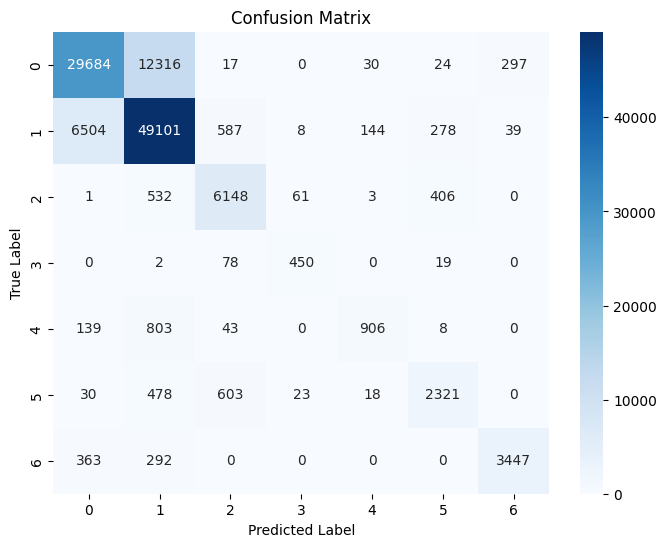

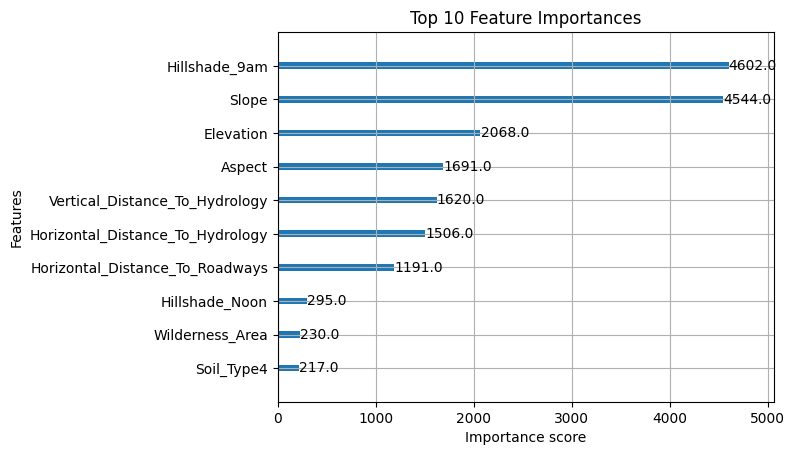

Do you want to save the trained model to Google Drive? (y/n): n
Model not saved.


In [5]:
# %% [markdown]
# # Task 3: Forest Cover Type Classification with XGBoost
# Predict forest cover types using cartographic and environmental features.
# GPU-accelerated training, evaluation, and saving the model to Google Drive.

# %% [code]
# Install dependencies (for Colab environment)
!pip install xgboost

# %% [code]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from google.colab import drive

# %% [markdown]
# ## Step 1: Load Dataset

# %% [code]


dataset_path = '/content/covertype.csv'

df = pd.read_csv(dataset_path)
print("Loaded dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nPreview:\n", df.head())

# %% [markdown]
# ## Step 2: Detect Target Column and Features

# %% [code]
target_column = "Cover_Type"
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset.")

print("\nDetected target column:", target_column)
print("\nClass distribution:\n", df[target_column].value_counts())

# Drop any unnamed index-like columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# %% [markdown]
# ## Step 3: Features and Labels

# %% [code]
X = df.drop(target_column, axis=1)
y = df[target_column]

# Shift labels to start from 0 (XGBoost requirement)
y = y - 1

print("Feature matrix shape:", X.shape)

# %% [markdown]
# ## Step 4: Train-Test Split

# %% [code]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# %% [markdown]
# ## Step 5: Train XGBoost Model

# %% [code]
clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y)),
    tree_method='gpu_hist',  # Use GPU if available
    predictor='gpu_predictor',
    eval_metric='mlogloss'
)

clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# %% [markdown]
# ## Step 6: Evaluation

# %% [code]
y_pred = clf.predict(X_test)

# Shift predictions back to original label range (1–7)
y_pred_original = y_pred + 1
y_test_original = y_test + 1

print("\nClassification Report:\n", classification_report(y_test_original, y_pred_original))

cm = confusion_matrix(y_test_original, y_pred_original)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# %% [markdown]
# ## Step 7: Feature Importance

# %% [code]
xgb.plot_importance(clf, max_num_features=10, importance_type='weight')
plt.title("Top 10 Feature Importances")
plt.show()

# %% [markdown]
# ## Step 8: Save Model to Google Drive

# %% [code]
save_model = input("Do you want to save the trained model to Google Drive? (y/n): ").lower()
if save_model == 'y':
    model_path = '/content/drive/MyDrive/xgb_forest_cover_model.joblib'
    joblib.dump(clf, model_path)
    print(f"Model saved to {model_path}")
else:
    print("Model not saved.")
